In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import gzip
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def cell_whitelist(barcode_file):
    whitelist = []
    with open(barcode_file) as wl:
        whitelist = [x[:-2] for x in wl.read().splitlines()]
    return whitelist

In [3]:
def ms_whitelist(barcode_file, sep = ',', skipfirst = False):
    if not skipfirst:
        return [x.split(sep)[0] for x in open(barcode_file).read().splitlines()]
    else:
         return [x.split(sep)[0] for x in open(barcode_file).read().splitlines()][1:]

In [4]:
def cells_to_reads(read1, read2, white, multiseqBool = True):
    cells = {}
    with gzip.open(read1, 'rt') as r1File, gzip.open(read2, 'rt') as r2File:
        count = 0
        for i, ((title1, seq1, qual1), (title2, seq2, qual2)) in tqdm(enumerate(zip(FastqGeneralIterator(r1File), FastqGeneralIterator(r2File)))):
            # Get the pieces of interest
            cell = seq1[0:16]
            if multiseqBool:
                UMI = seq1[17:27]
                multiseq = seq2[0:8]
            else:
                UMI = seq1[17:29]
                multiseq = seq2[0:18]
            coding = seq2[38:]
            
            read = {}
            read['umi'] = UMI
            read['multiseq'] = multiseq
            read['coding'] = coding
            
            # Only add cell barcodes that are in the whitelist
            if cell in white:
                if cell not in cells:
                    cells[cell] = []

                cells[cell].append(read)
    return cells

In [5]:
def flatten_UMI(cells):
    newCells = {}
    for cellid, cell in tqdm(cells.items()): # for each cell (by cell barcode)
        umis = []
        firstUniqueReads = []
        for read in cell: # for each read with that cell barcode, keep only unique
            if read['umi'] not in umis: 
                firstUniqueReads.append(read)
                umis.append(read['umi'])
        newCells[cellid] = firstUniqueReads
    return newCells

In [6]:
def map_barcodes(cells, mswhite):
    cellBarcodes = {}
    for cellid, cell in tqdm(cells.items()):
        ms = {} # multiseq barcodes
        for read in cell:
            if read['multiseq'] in mswhite:
                if read['multiseq'] in ms:
                    ms[read['multiseq']] = ms[read['multiseq']] + 1
                else:
                    ms[read['multiseq']] = 1
        cellBarcodes[cellid] = ms
    return cellBarcodes

In [7]:
def plot_counts(cellBarcodes, name, save = False):
    
    all_list = [val for sublist in [list(x.keys()) for x in cellBarcodes.values()] for val in sublist]
    targets = sorted(set(all_list), key = lambda x: sum([x == y for y in all_list]), reverse = True)[:3]
    
    f, ax = plt.subplots(figsize=(5, 5))

    for target in targets:
        counts = []
        for cell in cellBarcodes:
            barcodes = cellBarcodes[cell]
            for barcode in barcodes:
                if barcode == target:
                    counts.append(barcodes[barcode])

        df = pd.DataFrame({'counts':counts})            
        x = df.counts.tolist()
        x = [np.log(i) for i in x]

        sns.kdeplot(x, label = target)
    if save:
        plt.savefig("results/" + name + '_counts.png', bbox_inches='tight')


In [8]:
def threshold_for_barcode(target, data, cache):
    # Get the counts for target barcode from all the cells
    if target in cache.keys():
        return cache[target]
        
    counts = []
    for cell in data:
        barcodes = data[cell]
        for barcode in barcodes:
            if barcode == target:
                counts.append(barcodes[barcode])

    x = [[np.log(i)] for i in counts]
    
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=.5, kernel='gaussian')
    kde.fit(x)
    x_d = np.linspace(-4,8,2000)
    logprob = kde.score_samples(x_d[:, None])
    minm = argrelextrema(np.exp(logprob), np.less)  # (array([2, 5, 7]),)
    if len(minm[0]) > 0:
        cache[target] = x_d[minm[0][0]]
        return x_d[minm[0][0]]
    else:
        return 100

In [9]:
def get_final_labels(cellBarcodes):
    cache = {}
    finalMSLabels = {}
    for cellid, barcodes in tqdm(cellBarcodes.items()):
        aboveThresh = []
        sorted_counts = sorted(barcodes.values(), reverse = True)
        quality = float("inf")
        if len(sorted_counts) > 1:
            quality = sorted_counts[0]/sorted_counts[1]
        for barcode, count in barcodes.items():
            count = barcodes[barcode]
            if count >= np.exp(threshold_for_barcode(barcode, cellBarcodes, cache)):
                aboveThresh.append(barcode)
        if len(aboveThresh) == 1:
            finalMSLabels[cellid] = (aboveThresh[0], quality)
        else:
            finalMSLabels[cellid] = ("DOUBLET", quality)
    return finalMSLabels

In [10]:
def write_csv(cellBarcodes, name): 
    df = pd.DataFrame([(cell, ms, q) for cell, (ms, q) in cellBarcodes.items()], columns = ['cell barcode', 'multiseq barcode', 'quality'])
    df.to_csv("results/" + name + "_barcode_identities.csv")

In [11]:
def run_all(read1, read2, cell_wl, ms_wl, label, multiseqBool = True, save = True):
    cells = cells_to_reads(read1, read2, cell_whitelist(cell_wl), multiseqBool)
    unique_reads = flatten_UMI(cells)
    if multiseqBool:
        cell_barcodes = map_barcodes(unique_reads, ms_whitelist(ms_wl))
    else:
        cell_barcodes = map_barcodes(unique_reads, ms_whitelist(ms_wl, sep = "\t", skipfirst = True))
    plot_counts(cell_barcodes, label, save)
    final_labels = get_final_labels(cell_barcodes)
    write_csv(final_labels, label)

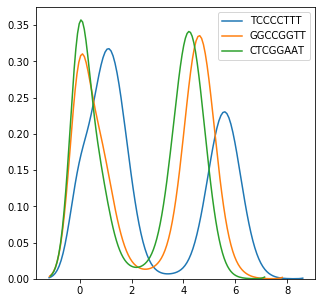

In [12]:
run_all("mk_dataset/HCC_MK_MS_S5_L001_R1_001.fastq.gz",
        "mk_dataset/HCC_MK_MS_S5_L001_R2_001.fastq.gz",
        'mk_dataset/cell-barcodes.tsv',
        'mk_dataset/LMOlist.csv',
        "MK"
       )

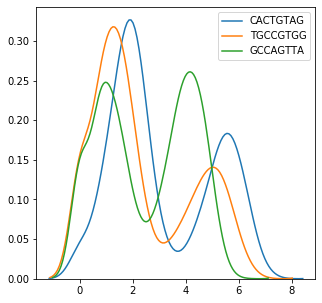

In [13]:
run_all("aa_dataset/HCC_AA_MS_S6_L001_R1_001.fastq.gz",
        "aa_dataset/HCC_AA_MS_S6_L001_R2_001.fastq.gz",
        'aa_dataset/cell-barcodes.tsv',
        'aa_dataset/LMOlist.csv',
        "AA"
       )

In [ ]:
run_all("gbc_dataset/BW-MDA_S1_L001_R1_001.trimmed.fastq.gz",
        "gbc_dataset/BW-MDA_S1_L001_R2_001.trimmed.fastq.gz",
        'gbc_dataset/cell-barcodes.tsv',
        'gbc_dataset/genetic_barcodes.txt',
        "GBC",
        multiseqBool = False
       )